# Time-Series Prediction



https://www.phmsociety.org/sites/phmsociety.org/files/PHM%20Data%20Challenge%202018%20vFinal%20v2_0.pdf
\
https://www.phmsociety.org/events/conference/phm/18/data-challenge

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import sys
from sklearn.preprocessing import MinMaxScaler

In [3]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [4]:
sys.version

'3.7.4 (tags/v3.7.4:e09359112e, Jul  8 2019, 20:34:20) [MSC v.1916 64 bit (AMD64)]'

In [5]:
tf.__version__

'1.14.0'

In [6]:
tf.keras.__version__

'2.2.4-tf'

In [7]:
pd.__version__

'0.25.3'

***

In [8]:
data_dir = r"D:\data\phm_data_challenge_2018\train"

In [9]:
from glob import glob

train_files = glob(os.path.join(data_dir, "")+"*.csv")
train_ttf_files = glob(os.path.join(data_dir, "train_ttf")+"/*.csv")
train_fault_files = glob(os.path.join(data_dir, "train_faults")+"/*.csv")

In [10]:
%%time
train = pd.read_csv(train_files[5])
train_faults = pd.read_csv(train_fault_files[5])
train_ttf = pd.read_csv(train_ttf_files[5])

Wall time: 22.7 s


In [11]:
train.head()

,time,Tool,stage,Lot,runnum,recipe,recipe_step,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,ETCHBEAMCURRENT,...,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ROTATIONSPEED,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ETCHAUXSOURCETIMER,ETCHAUX2SOURCETIMER,ACTUALSTEPDURATION
0,3284714,03M02,1,640,10511726,249,1,-1.547961,-1.222222,-1.272007,...,-1.575525,-1.601477,1.363214,-0.00277,-0.178652,0,0.471536,-0.811703,-0.217482,1.772975
1,3284720,03M02,1,640,10511726,249,1,-1.547446,-1.221113,-1.272404,...,-1.575525,-1.601477,1.363214,-0.00277,-0.178652,0,0.471536,-0.811703,-0.217482,1.772975
2,3284722,03M02,1,640,10511726,249,1,-1.546922,-1.221020,-1.272007,...,-1.575525,-1.601477,1.363214,-0.00277,-0.178652,0,0.471536,-0.811703,-0.217482,1.772975
3,3284726,03M02,1,640,10511726,249,1,-1.547770,-1.221205,-1.271928,...,-1.575525,-1.601477,1.363214,-0.00277,-0.178652,0,0.471536,-0.811703,-0.217482,1.772975
4,3284730,03M02,1,640,10511726,249,1,-1.548045,-1.222407,-1.271769,...,-1.575525,-1.601477,1.363214,-0.00277,-0.178652,0,0.471536,-0.811703,-0.217482,1.772975


In [12]:
train_faults.head()

,time,fault_name,Tool
0,3326152,FlowCool Pressure Dropped Below Limit,03M02
1,3780688,FlowCool Pressure Dropped Below Limit,03M02
2,3961378,FlowCool Pressure Dropped Below Limit,03M02
3,4528896,FlowCool Pressure Dropped Below Limit,03M02
4,4528896,FlowCool Pressure Dropped Below Limit,03M02


In [13]:
(train_faults.fault_name.unique())

array(['FlowCool Pressure Dropped Below Limit',
       'Flowcool Pressure Too High Check Flowcool Pump', 'Flowcool leak',
       'Flowcool Pressure Too High Check Flowcool Pump [NoWaferID]'],
      dtype=object)

In [14]:
train_ttf.head()

,time,TTF_FlowCool Pressure Dropped Below Limit,TTF_Flowcool Pressure Too High Check Flowcool Pump,TTF_Flowcool leak
0,3284714,41438.0,1699604.0,16250708.0
1,3284720,41432.0,1699598.0,16250702.0
2,3284722,41430.0,1699596.0,16250700.0
3,3284726,41426.0,1699592.0,16250696.0
4,3284730,41422.0,1699588.0,16250692.0


In [15]:
len(train)

5060498

In [16]:
# merge train and train_time_to_fault

ttf_any = list(map(min, train_ttf.iloc[:,1:].values))
train['ttf_any'] = ttf_any

In [17]:
train.head()

,time,Tool,stage,Lot,runnum,recipe,recipe_step,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,ETCHBEAMCURRENT,...,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ROTATIONSPEED,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ETCHAUXSOURCETIMER,ETCHAUX2SOURCETIMER,ACTUALSTEPDURATION,ttf_any
0,3284714,03M02,1,640,10511726,249,1,-1.547961,-1.222222,-1.272007,...,-1.601477,1.363214,-0.00277,-0.178652,0,0.471536,-0.811703,-0.217482,1.772975,41438.0
1,3284720,03M02,1,640,10511726,249,1,-1.547446,-1.221113,-1.272404,...,-1.601477,1.363214,-0.00277,-0.178652,0,0.471536,-0.811703,-0.217482,1.772975,41432.0
2,3284722,03M02,1,640,10511726,249,1,-1.546922,-1.221020,-1.272007,...,-1.601477,1.363214,-0.00277,-0.178652,0,0.471536,-0.811703,-0.217482,1.772975,41430.0
3,3284726,03M02,1,640,10511726,249,1,-1.547770,-1.221205,-1.271928,...,-1.601477,1.363214,-0.00277,-0.178652,0,0.471536,-0.811703,-0.217482,1.772975,41426.0
4,3284730,03M02,1,640,10511726,249,1,-1.548045,-1.222407,-1.271769,...,-1.601477,1.363214,-0.00277,-0.178652,0,0.471536,-0.811703,-0.217482,1.772975,41422.0


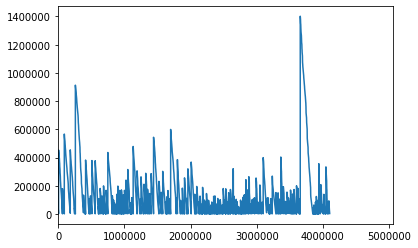

In [18]:
train.ttf_any.plot()

In [19]:
# % of the tail time with no faults
len(train_ttf[pd.isna(train.ttf_any)]) /len(train_ttf)

0.18909107364532107

In [20]:
# remove after the last fault nan
train = train[~pd.isna(train.ttf_any)]

In [21]:
len(train)

4103603

In [22]:
# dropping irrelevant columns
drop_list=["Tool", ]

In [23]:
train = train.drop(drop_list, axis=1)

In [24]:
train.columns

Index(['time', 'stage', 'Lot', 'runnum', 'recipe', 'recipe_step',
       'IONGAUGEPRESSURE', 'ETCHBEAMVOLTAGE', 'ETCHBEAMCURRENT',
       'ETCHSUPPRESSORVOLTAGE', 'ETCHSUPPRESSORCURRENT', 'FLOWCOOLFLOWRATE',
       'FLOWCOOLPRESSURE', 'ETCHGASCHANNEL1READBACK', 'ETCHPBNGASREADBACK',
       'FIXTURETILTANGLE', 'ROTATIONSPEED', 'ACTUALROTATIONANGLE',
       'FIXTURESHUTTERPOSITION', 'ETCHSOURCEUSAGE', 'ETCHAUXSOURCETIMER',
       'ETCHAUX2SOURCETIMER', 'ACTUALSTEPDURATION', 'ttf_any'],
      dtype='object')

***

***

In [25]:
shift_steps = 100

In [26]:
train_target = train
train_target['ttf_any'] = train_target['ttf_any'].shift(-shift_steps) 
train_target

,time,stage,Lot,runnum,recipe,recipe_step,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,ETCHBEAMCURRENT,ETCHSUPPRESSORVOLTAGE,...,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ROTATIONSPEED,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ETCHAUXSOURCETIMER,ETCHAUX2SOURCETIMER,ACTUALSTEPDURATION,ttf_any
0,3284714,1,640,10511726,249,1,-1.547961,-1.222222,-1.272007,-1.468476,...,-1.601477,1.363214,-0.00277,-0.178652,0,0.471536,-0.811703,-0.217482,1.772975,41036.0
1,3284720,1,640,10511726,249,1,-1.547446,-1.221113,-1.272404,-1.468567,...,-1.601477,1.363214,-0.00277,-0.178652,0,0.471536,-0.811703,-0.217482,1.772975,41034.0
2,3284722,1,640,10511726,249,1,-1.546922,-1.221020,-1.272007,-1.468522,...,-1.601477,1.363214,-0.00277,-0.178652,0,0.471536,-0.811703,-0.217482,1.772975,41030.0
3,3284726,1,640,10511726,249,1,-1.547770,-1.221205,-1.271928,-1.468567,...,-1.601477,1.363214,-0.00277,-0.178652,0,0.471536,-0.811703,-0.217482,1.772975,41026.0
4,3284730,1,640,10511726,249,1,-1.548045,-1.222407,-1.271769,-1.468522,...,-1.601477,1.363214,-0.00277,-0.178652,0,0.471536,-0.811703,-0.217482,1.772975,41022.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4103598,37498076,113,483,12683151,143,5,-1.491357,-1.222037,-1.271848,-1.467752,...,-1.581964,1.363214,-0.00277,-0.178645,0,-0.423471,1.093862,-0.745341,-0.658597,NaN
4103599,37498080,113,483,12683151,143,5,-1.500010,-1.221760,-1.271610,-1.467842,...,-1.581964,1.363214,-0.00277,-0.178645,0,-0.423471,1.093862,-0.745341,-0.658597,NaN
4103600,37498084,113,483,12683151,143,5,-1.502536,-1.222222,-1.272007,-1.467933,...,-1.581964,1.363214,-0.00277,-0.178645,0,-0.423471,1.093862,-0.745341,-0.658597,NaN
4103601,37498088,113,483,12683151,143,5,-1.507284,-1.221852,-1.271769,-1.467797,...,-1.581964,1.363214,-0.00277,-0.178645,0,-0.423471,1.093862,-0.745341,-0.658597,NaN


### Scaled Data

In [27]:
scaler = MinMaxScaler()

In [28]:
df_scaled = pd.DataFrame(scaler.fit_transform(train_target), columns=train_target.columns)
df_scaled

,time,stage,Lot,runnum,recipe,recipe_step,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,ETCHBEAMCURRENT,ETCHSUPPRESSORVOLTAGE,...,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ROTATIONSPEED,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ETCHAUXSOURCETIMER,ETCHAUX2SOURCETIMER,ACTUALSTEPDURATION,ttf_any
0,0.000000e+00,0.003460,0.030732,0.0,0.827103,0.023256,0.000004,0.000278,0.000610,0.001668,...,0.076232,0.156772,0.5,0.5,0.0,0.592694,0.246850,0.398852,0.200000,0.029279
1,1.753700e-07,0.003460,0.030732,0.0,0.827103,0.023256,0.000005,0.000564,0.000534,0.001636,...,0.076232,0.156772,0.5,0.5,0.0,0.592694,0.246850,0.398852,0.200000,0.029278
2,2.338267e-07,0.003460,0.030732,0.0,0.827103,0.023256,0.000005,0.000588,0.000610,0.001652,...,0.076232,0.156772,0.5,0.5,0.0,0.592694,0.246850,0.398852,0.200000,0.029275
3,3.507400e-07,0.003460,0.030732,0.0,0.827103,0.023256,0.000004,0.000540,0.000626,0.001636,...,0.076232,0.156772,0.5,0.5,0.0,0.592694,0.246850,0.398852,0.200000,0.029272
4,4.676533e-07,0.003460,0.030732,0.0,0.827103,0.023256,0.000004,0.000231,0.000656,0.001652,...,0.076232,0.156772,0.5,0.5,0.0,0.592694,0.246850,0.398852,0.200000,0.029269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4103598,9.999995e-01,0.391003,0.023193,1.0,0.331776,0.116279,0.000097,0.000326,0.000641,0.001925,...,0.081598,0.156772,0.5,0.5,0.0,0.339563,0.744441,0.218255,0.012593,NaN
4103599,9.999996e-01,0.391003,0.023193,1.0,0.331776,0.116279,0.000083,0.000397,0.000687,0.001893,...,0.081598,0.156772,0.5,0.5,0.0,0.339563,0.744441,0.218255,0.012593,NaN
4103600,9.999998e-01,0.391003,0.023193,1.0,0.331776,0.116279,0.000079,0.000278,0.000610,0.001861,...,0.081598,0.156772,0.5,0.5,0.0,0.339563,0.744441,0.218255,0.012593,NaN
4103601,9.999999e-01,0.391003,0.023193,1.0,0.331776,0.116279,0.000071,0.000374,0.000656,0.001909,...,0.081598,0.156772,0.5,0.5,0.0,0.339563,0.744441,0.218255,0.012593,NaN


In [29]:
train_target = df_scaled

In [30]:
## Double brackets for the right shape
y_data = train_target[['ttf_any']].values[:-shift_steps]

print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (4103503, 1)


In [31]:
train_target = train_target.drop('ttf_any', axis=1)

In [32]:
x_data = train_target.values[0:-shift_steps]

print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (4103503, 23)


In [33]:
del(train_target)
del(train)
del(train_faults)
del(train_ttf)
del(df_scaled)

Number of observations:

In [34]:
num_data = len(x_data)
num_data

4103503

Validation data splitting:

In [35]:
train_split = 0.9

In [36]:
num_train = int(train_split * num_data)
num_train

3693152

In [37]:
num_test = num_data - num_train
num_test

410351

Train and Validation inputs:

In [38]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

4103503

Train and Validation output:

In [39]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

4103503

Number of input-signals:

In [40]:
num_x_signals = x_data.shape[1]
num_x_signals

23

Number of output-signals:

In [41]:
num_y_signals = y_data.shape[1]
num_y_signals

1

## Already scaled

In [42]:
print(x_train.shape)
print(y_train.shape)

(3693152, 23)
(3693152, 1)


## Data Generator

In [43]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train[idx:idx+sequence_length]
            y_batch[i] = y_train[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

Low RAM; small batch size :(

In [44]:
batch_size = 8

## Time window

BOTTOM TEXT

How long back to go to predict the current value

In [45]:
sequence_length = 2000
sequence_length

2000

***

In [46]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

Test obtaining a batch:

In [47]:
x_batch, y_batch = next(generator)

In [48]:
print(x_batch.shape)
print(y_batch.shape)

(8, 2000, 23)
(8, 2000, 1)


Plot one signal for example

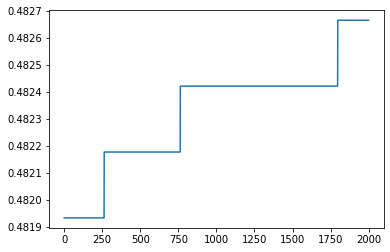

In [49]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

Plot y

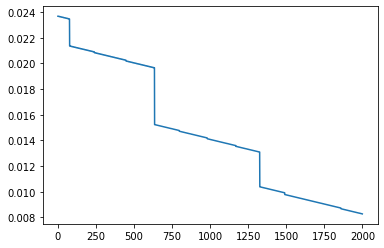

In [50]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

### Validation Data

In [52]:
validation_data = (np.expand_dims(x_test, axis=0),
                   np.expand_dims(y_test, axis=0))

## The Recurrent Neural Network

In [53]:
model = Sequential()

Gated Recurrent Unit (GRU) with 512 outputs for each time-step in the sequence.

Each observation has a number of input-signals (`num_x_signals`).

In [54]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

W0106 17:01:39.459206 15080 deprecation.py:506] From c:\pphiles\python37\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [55]:
model.add(Dense(num_y_signals, activation='sigmoid'))

Mean Squared Error (MSE) for loss function.

At the beginning of a sequence, the model would have seen only a few signals which makes it innacurate, this affects the loss and messes with the training.

In [56]:
warmup_steps = 50

In [57]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

### Compile Model

In [58]:
optimizer = RMSprop(lr=1e-3)

In [59]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

W0106 17:01:51.845839 15080 deprecation.py:323] From c:\pphiles\python37\lib\site-packages\tensorflow\python\ops\losses\losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [60]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         823296    
_________________________________________________________________
dense (Dense)                (None, None, 1)           513       
Total params: 823,809
Trainable params: 823,809
Non-trainable params: 0
_________________________________________________________________


### Callback Functions

In [64]:
path_checkpoint = 'PHM.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [66]:
callback_tensorboard = TensorBoard(log_dir='./PHM_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

This is the callback for stopping the optimization when performance worsens on the validation-set.

In [65]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

This callback reduces the learning-rate for the optimizer if the validation-loss has not improved since the last epoch.

In [67]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [68]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

## Train the Recurrent Neural Network

In [70]:
%%time
model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/20
 99/100 [============================>.] - ETA: 5s - loss: 0.0193 
Epoch 00001: val_loss improved from inf to 0.07125, saving model to PHM.keras
100/100 [==============================] - 848s 8s/step - loss: 0.0191 - val_loss: 0.0712
Epoch 2/20
 99/100 [============================>.] - ETA: 5s - loss: 0.0227 
Epoch 00002: val_loss improved from 0.07125 to 0.06442, saving model to PHM.keras
100/100 [==============================] - 716s 7s/step - loss: 0.0225 - val_loss: 0.0644
Epoch 3/20
 99/100 [============================>.] - ETA: 5s - loss: 0.0194 
Epoch 00003: val_loss improved from 0.06442 to 0.06108, saving model to PHM.keras
100/100 [==============================] - 701s 7s/step - loss: 0.0193 - val_loss: 0.0611
Epoch 4/20
 99/100 [============================>.] - ETA: 5s - loss: 0.0164 
Epoch 00004: val_loss improved from 0.06108 to 0.05863, saving model to PHM.keras
100/100 [==============================] - 714s 7s/step - loss: 0.0163 - val_loss: 0.0586
Epoc

In [71]:
model.save("model1layer.h5")

should include the time column?

Scale before or after transforming

which columns to scale?

scaling method

## Evaluate

In [73]:
result = model.evaluate(x=np.expand_dims(x_test, axis=0),
                        y=np.expand_dims(y_test, axis=0))

1/1 [==============================] - 121s 121s/sample - loss: 0.0235


In [74]:
print("loss (test-set):", result)

loss (test-set): 0.023536188527941704


## Predict

In [104]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    """
    
    if train:
        # Use training-data.
        x = x_train
        y_true = y_train
        print(y_true.shape)
        
        y_true_padded = np.zeros((len(y_true), 24))
        y_true_padded[:,:-1] = y_true
        y_true_rescaled = scaler.inverse_transform(y_true_padded)
        y_true = y_true_rescaled
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    end_idx = start_idx + length
    
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    x = np.expand_dims(x, axis=0)

    y_pred = model.predict(x)

    # rescale to the original data-set.
    y_pred_padded = np.zeros((len(y_pred[0]), 24))
    y_pred_padded[:,:-1] = y_pred
    #y_pred_padded = y_pred
    y_pred_rescaled = scaler.inverse_transform(y_pred_padded)
    
    for signal in range(1):
        signal_pred = y_pred_rescaled[:, signal]
        
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel('time_to_fault')
        plt.legend()
        plt.show()

In [105]:
4103603

4103603

(3693152, 1)


c:\pphiles\python37\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


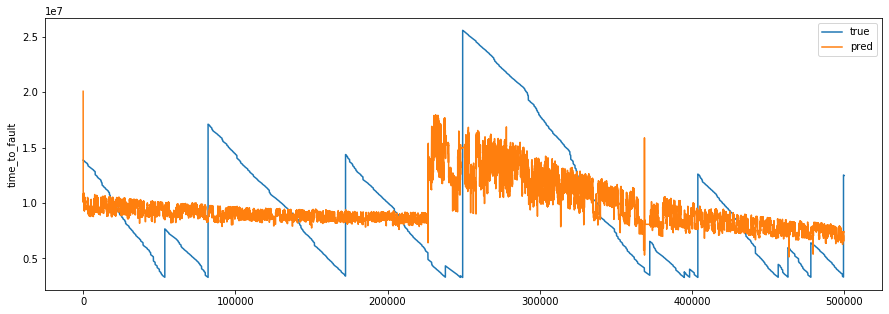

In [106]:
y_pred = plot_comparison(start_idx=10000, length=500000, train=True)

(3693152, 1)


c:\pphiles\python37\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


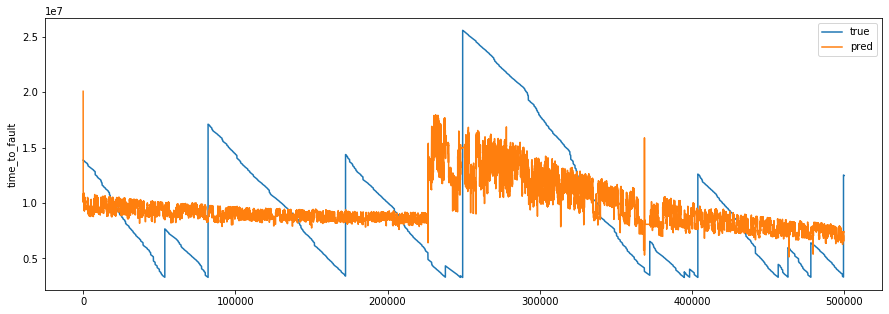

In [100]:
y_pred = plot_comparison(start_idx=10000, length=500000, train=True)